In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [2]:
# 1. Load and preprocess dataset
df = pd.read_csv('DATASET_FINAL_NO_STOPWORDS.csv')

In [3]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [4]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

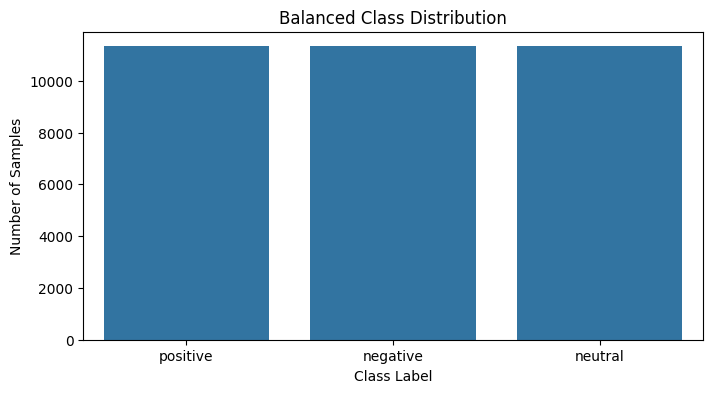

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Balance the dataset by upsampling minority classes
from sklearn.utils import resample

# Combine texts and labels into a DataFrame
balance_df = pd.DataFrame({'text': texts, 'label': labels})

# Find the maximum class size
max_size = balance_df['label'].value_counts().max()

# Upsample each class to max_size
balanced_list = []
for label in balance_df['label'].unique():
    class_subset = balance_df[balance_df['label'] == label]
    upsampled = resample(class_subset, replace=True, n_samples=max_size, random_state=42)
    balanced_list.append(upsampled)
balanced_df = pd.concat(balanced_list)

# Visualize new class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=balanced_df['label'])
plt.title('Balanced Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# Update texts and labels for further processing
texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

In [6]:
# Re-encode labels after balancing
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [7]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [8]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    # Track and plot training/validation loss and accuracy for each fold and model
    train_histories = {'CNN': [], 'RNN': [], 'LSTM': []}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_cat[train_idx], y_cat[val_idx]
        y_val_labels = y[val_idx]
        vocab_size = min(10000, len(tokenizer.word_index) + 1)

        for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
            model = build_fn(maxlen, vocab_size, num_classes)
            history = model.fit(
                X_train, y_train,
                epochs=5,
                batch_size=32,
                verbose=0,
                validation_data=(X_val, y_val)
            )
            train_histories[name].append(history)


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 CNN: Acc=0.8738, Prec=0.8751, Rec=0.8738, F1=0.8743, MCC=0.8108, MSE=0.1642, RMSE=0.4052, R2=0.7549
Fold 1 CNN: Acc=0.8738, Prec=0.8751, Rec=0.8738, F1=0.8743, MCC=0.8108, MSE=0.1642, RMSE=0.4052, R2=0.7549


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 RNN: Acc=0.8608, Prec=0.8614, Rec=0.8608, F1=0.8610, MCC=0.7914, MSE=0.1828, RMSE=0.4276, R2=0.7270
Fold 1 RNN: Acc=0.8608, Prec=0.8614, Rec=0.8608, F1=0.8610, MCC=0.7914, MSE=0.1828, RMSE=0.4276, R2=0.7270


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 1 LSTM: Acc=0.8511, Prec=0.8511, Rec=0.8511, F1=0.8511, MCC=0.7767, MSE=0.1961, RMSE=0.4428, R2=0.7073
Fold 1 LSTM: Acc=0.8511, Prec=0.8511, Rec=0.8511, F1=0.8511, MCC=0.7767, MSE=0.1961, RMSE=0.4428, R2=0.7073


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 CNN: Acc=0.8719, Prec=0.8724, Rec=0.8719, F1=0.8720, MCC=0.8079, MSE=0.1665, RMSE=0.4081, R2=0.7482
Fold 2 CNN: Acc=0.8719, Prec=0.8724, Rec=0.8719, F1=0.8720, MCC=0.8079, MSE=0.1665, RMSE=0.4081, R2=0.7482


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 2 RNN: Acc=0.8026, Prec=0.8107, Rec=0.8026, F1=0.8014, MCC=0.7081, MSE=0.2958, RMSE=0.5439, R2=0.5527
Fold 2 RNN: Acc=0.8026, Prec=0.8107, Rec=0.8026, F1=0.8014, MCC=0.7081, MSE=0.2958, RMSE=0.5439, R2=0.5527


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 2 LSTM: Acc=0.8541, Prec=0.8551, Rec=0.8541, F1=0.8544, MCC=0.7812, MSE=0.1940, RMSE=0.4405, R2=0.7066
Fold 2 LSTM: Acc=0.8541, Prec=0.8551, Rec=0.8541, F1=0.8544, MCC=0.7812, MSE=0.1940, RMSE=0.4405, R2=0.7066


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 CNN: Acc=0.8694, Prec=0.8689, Rec=0.8694, F1=0.8686, MCC=0.8045, MSE=0.1906, RMSE=0.4366, R2=0.7152Fold 3 CNN: Acc=0.8694, Prec=0.8689, Rec=0.8694, F1=0.8686, MCC=0.8045, MSE=0.1906, RMSE=0.4366, R2=0.7152



c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 3 RNN: Acc=0.8580, Prec=0.8604, Rec=0.8580, F1=0.8585, MCC=0.7878, MSE=0.1971, RMSE=0.4440, R2=0.7055
Fold 3 RNN: Acc=0.8580, Prec=0.8604, Rec=0.8580, F1=0.8585, MCC=0.7878, MSE=0.1971, RMSE=0.4440, R2=0.7055


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 3 LSTM: Acc=0.8486, Prec=0.8498, Rec=0.8486, F1=0.8487, MCC=0.7734, MSE=0.2132, RMSE=0.4617, R2=0.6816Fold 3 LSTM: Acc=0.8486, Prec=0.8498, Rec=0.8486, F1=0.8487, MCC=0.7734, MSE=0.2132, RMSE=0.4617, R2=0.6816



c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 CNN: Acc=0.8607, Prec=0.8606, Rec=0.8607, F1=0.8606, MCC=0.7910, MSE=0.1954, RMSE=0.4420, R2=0.7105Fold 4 CNN: Acc=0.8607, Prec=0.8606, Rec=0.8607, F1=0.8606, MCC=0.7910, MSE=0.1954, RMSE=0.4420, R2=0.7105



c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 4 RNN: Acc=0.8520, Prec=0.8537, Rec=0.8520, F1=0.8525, MCC=0.7784, MSE=0.2076, RMSE=0.4556, R2=0.6925Fold 4 RNN: Acc=0.8520, Prec=0.8537, Rec=0.8520, F1=0.8525, MCC=0.7784, MSE=0.2076, RMSE=0.4556, R2=0.6925



c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Fold 4 LSTM: Acc=0.8420, Prec=0.8408, Rec=0.8420, F1=0.8410, MCC=0.7633, MSE=0.2277, RMSE=0.4772, R2=0.6626
Fold 4 LSTM: Acc=0.8420, Prec=0.8408, Rec=0.8420, F1=0.8410, MCC=0.7633, MSE=0.2277, RMSE=0.4772, R2=0.6626


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5 CNN: Acc=0.8585, Prec=0.8576, Rec=0.8585, F1=0.8575, MCC=0.7883, MSE=0.1909, RMSE=0.4370, R2=0.7097
Fold 5 CNN: Acc=0.8585, Prec=0.8576, Rec=0.8585, F1=0.8575, MCC=0.7883, MSE=0.1909, RMSE=0.4370, R2=0.7097


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 5 RNN: Acc=0.8450, Prec=0.8469, Rec=0.8450, F1=0.8456, MCC=0.7676, MSE=0.2036, RMSE=0.4512, R2=0.6904Fold 5 RNN: Acc=0.8450, Prec=0.8469, Rec=0.8450, F1=0.8456, MCC=0.7676, MSE=0.2036, RMSE=0.4512, R2=0.6904



c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 5 LSTM: Acc=0.8398, Prec=0.8402, Rec=0.8398, F1=0.8397, MCC=0.7598, MSE=0.2101, RMSE=0.4583, R2=0.6806Fold 5 LSTM: Acc=0.8398, Prec=0.8402, Rec=0.8398, F1=0.8397, MCC=0.7598, MSE=0.2101, RMSE=0.4583, R2=0.6806



c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


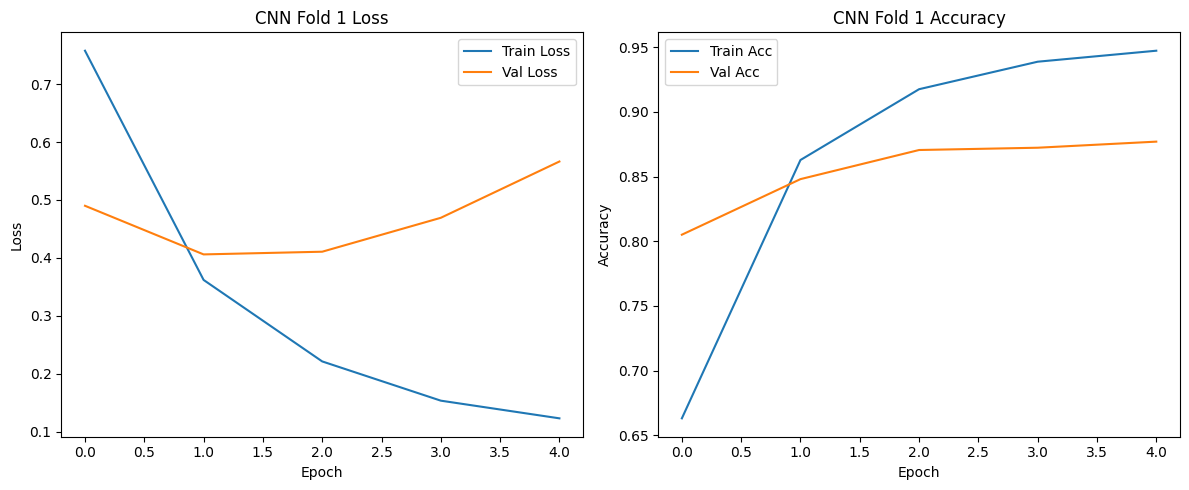

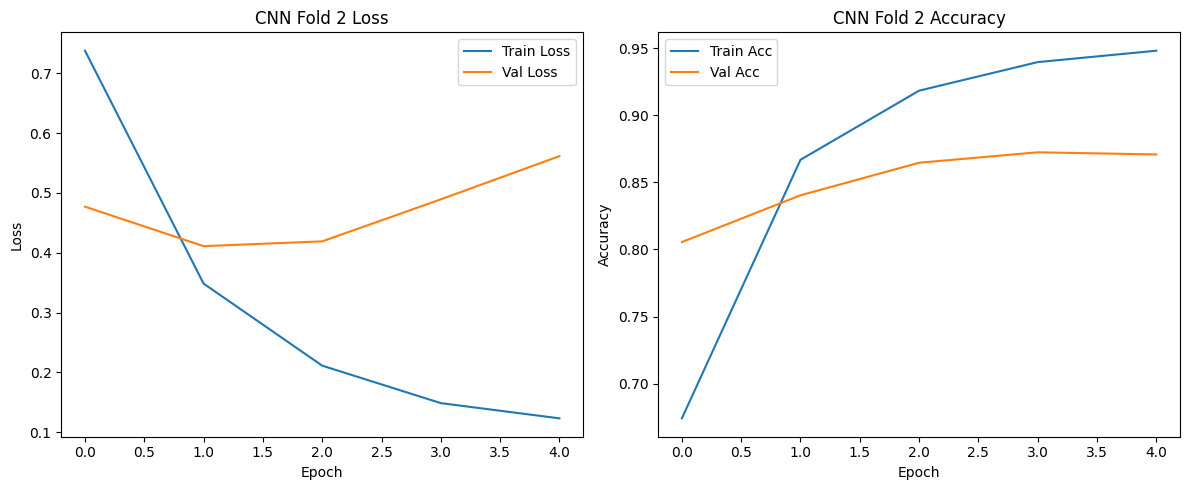

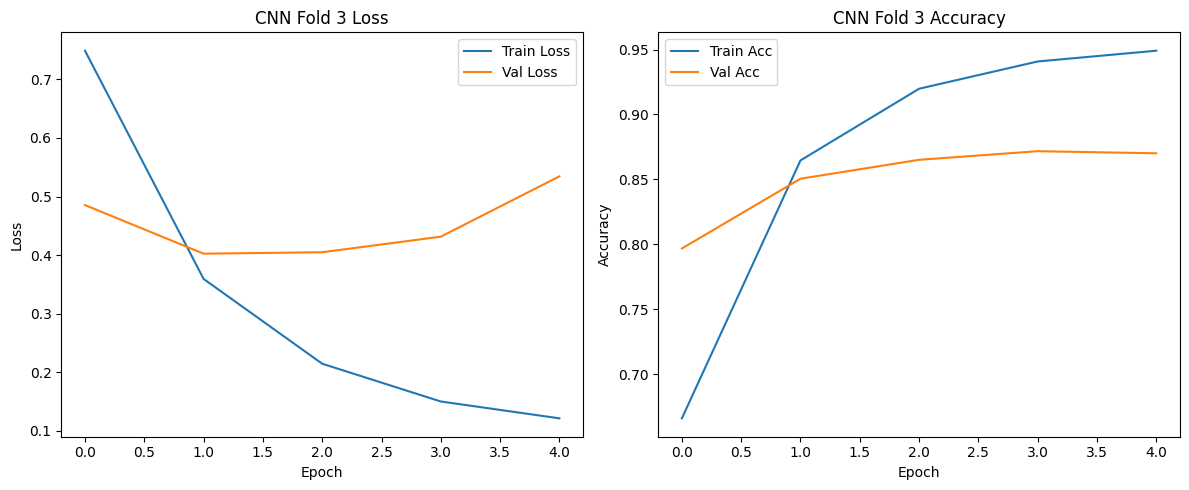

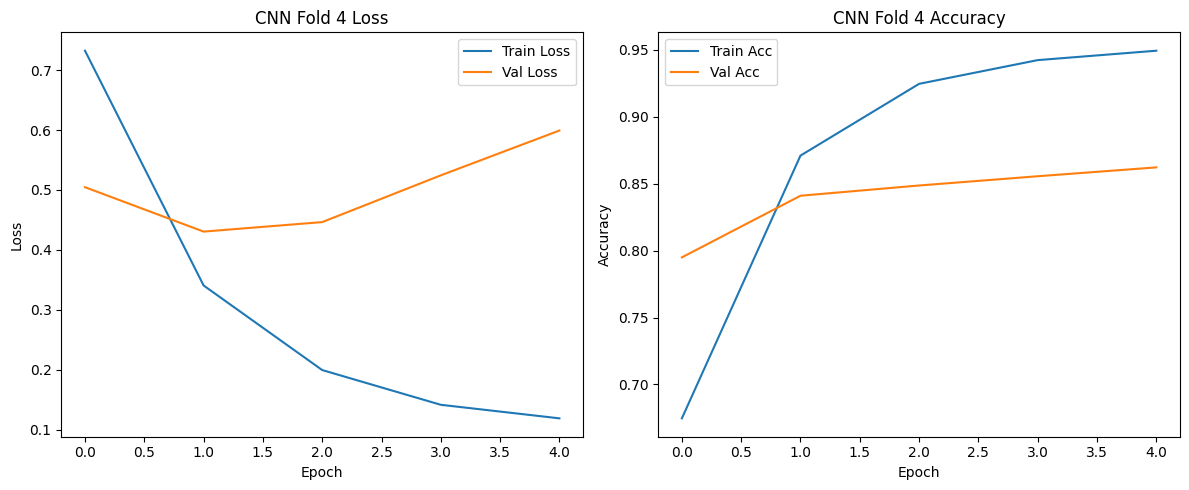

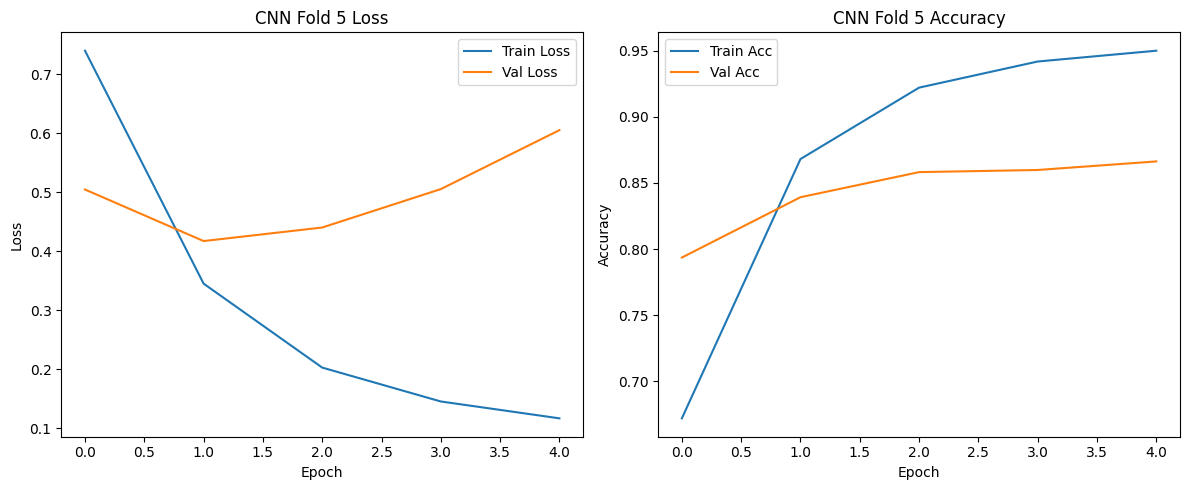

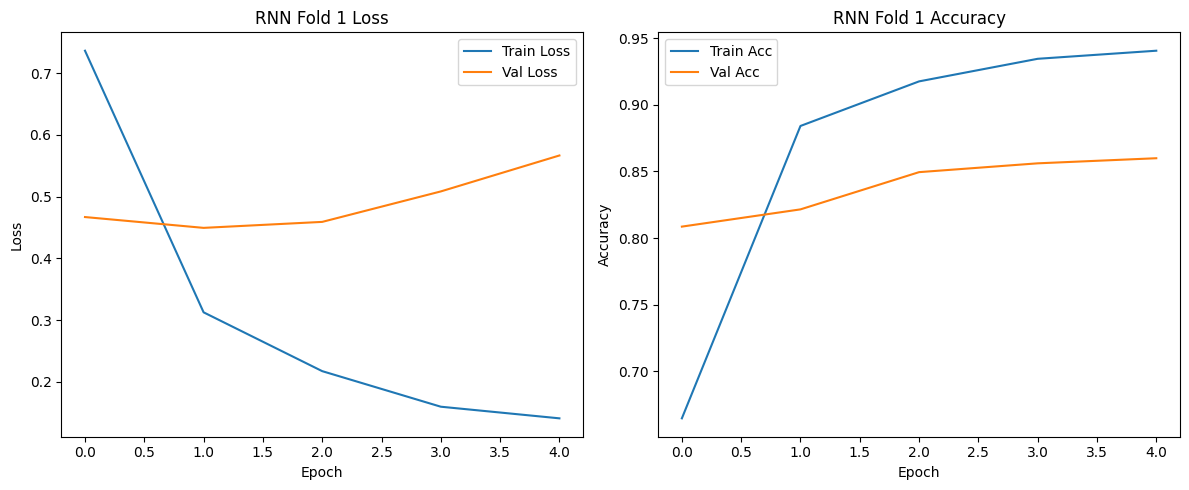

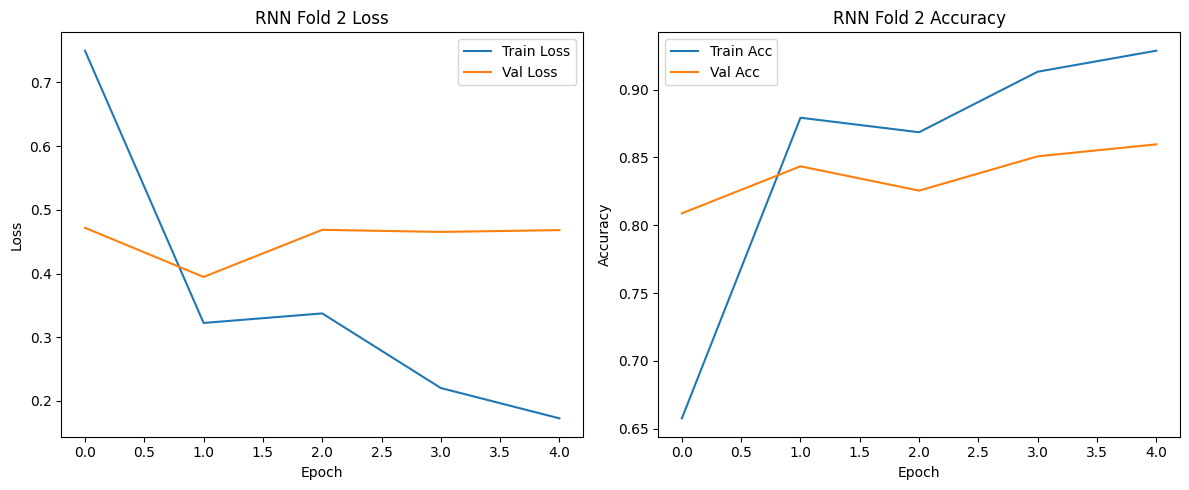

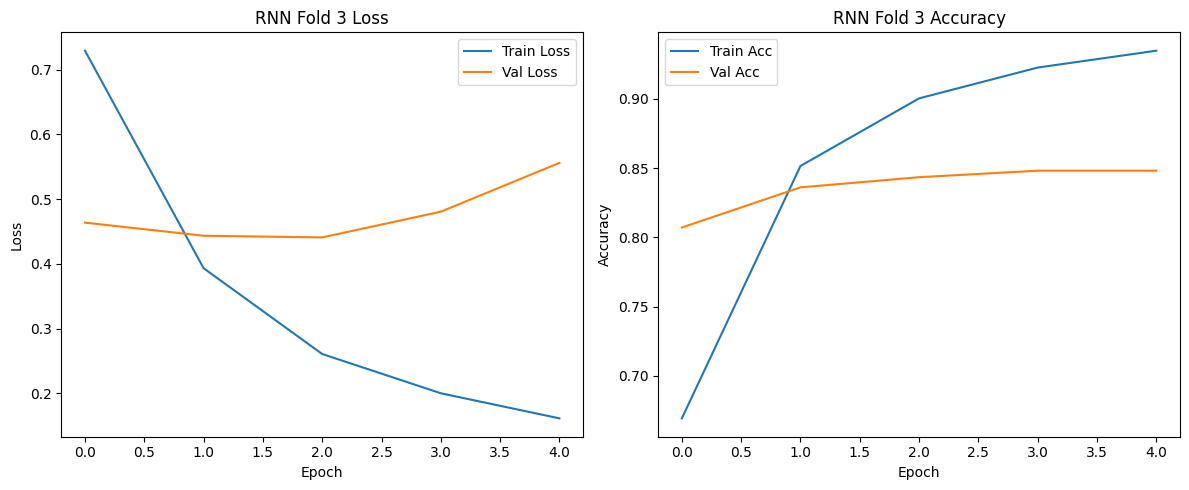

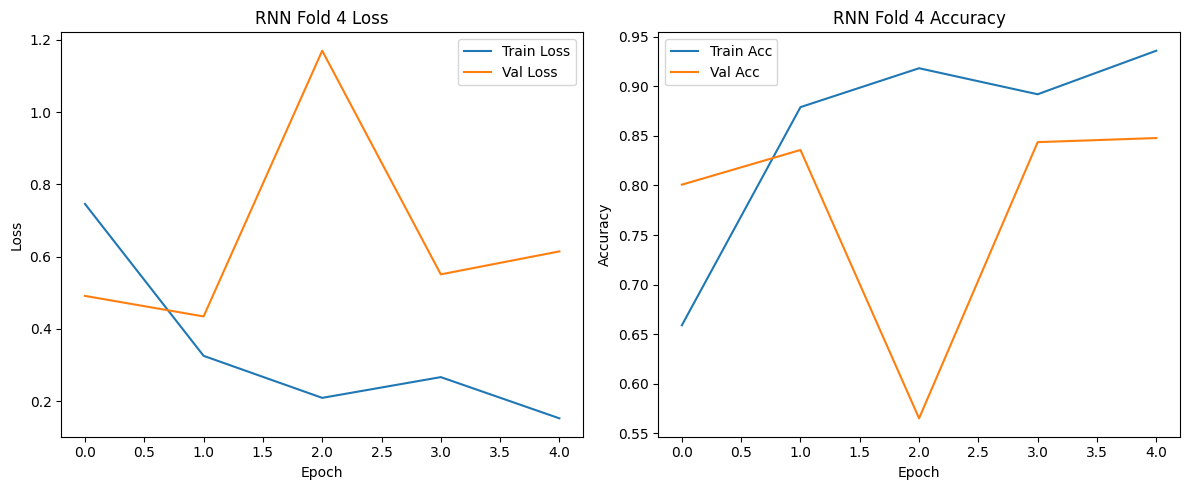

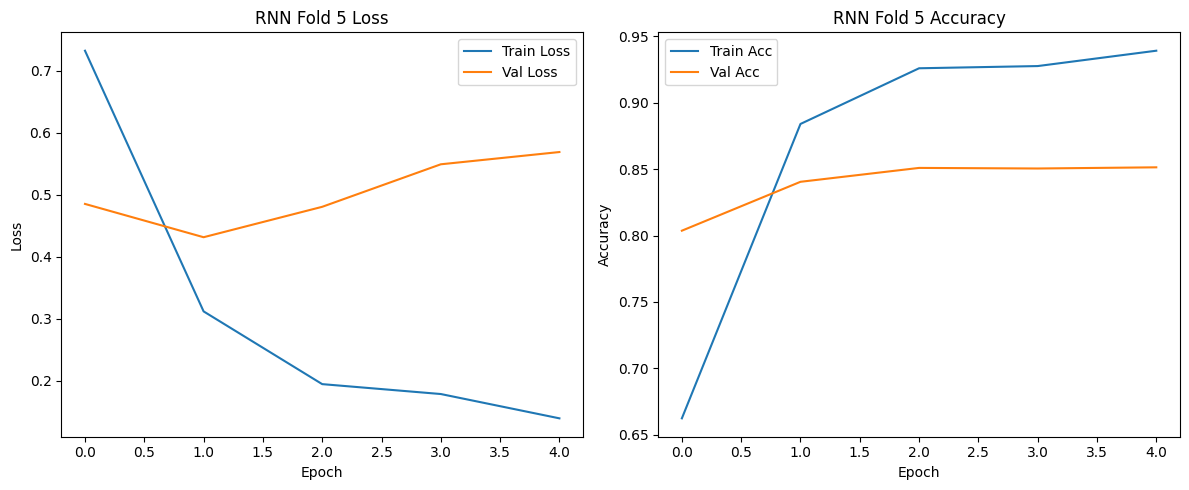

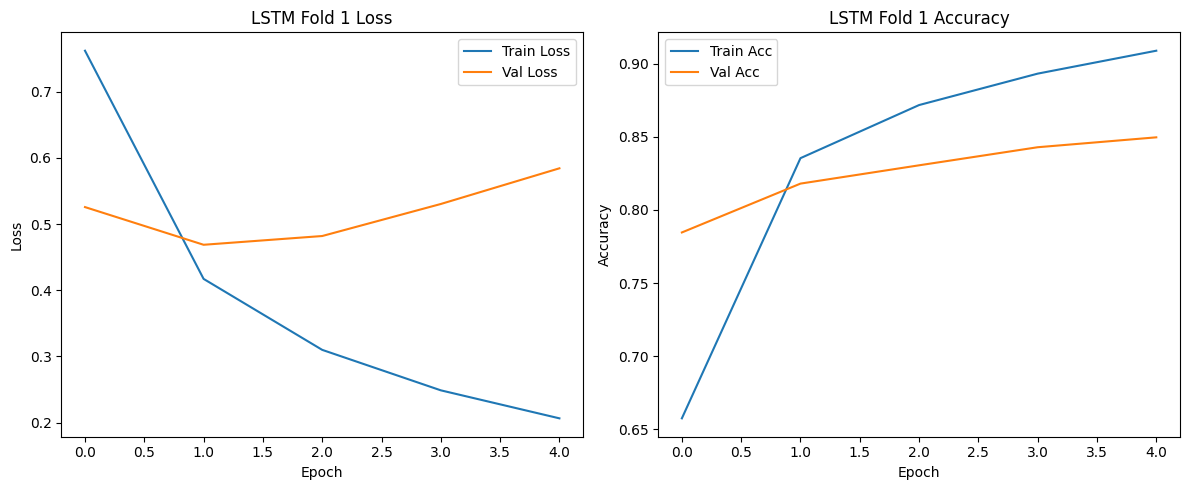

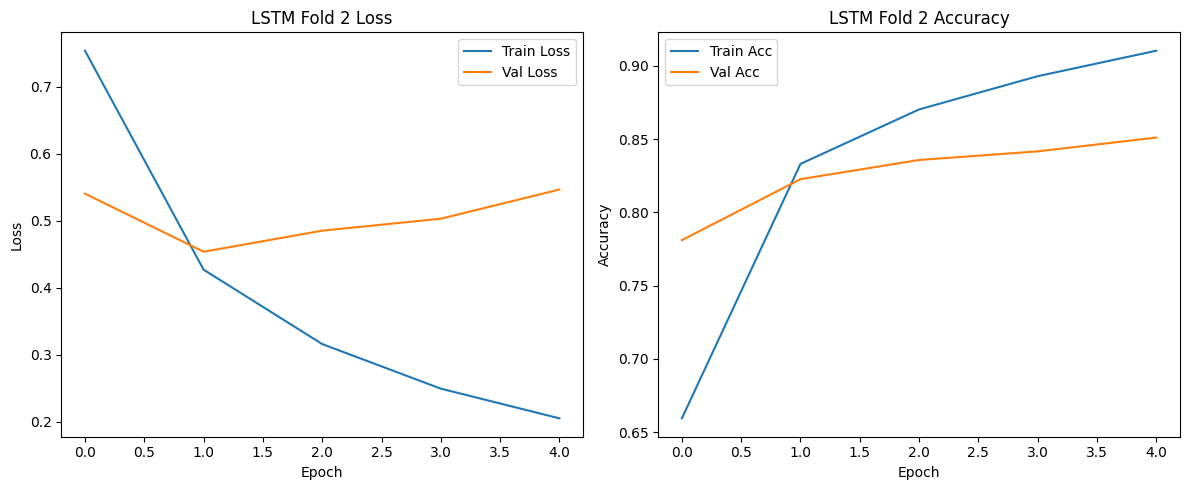

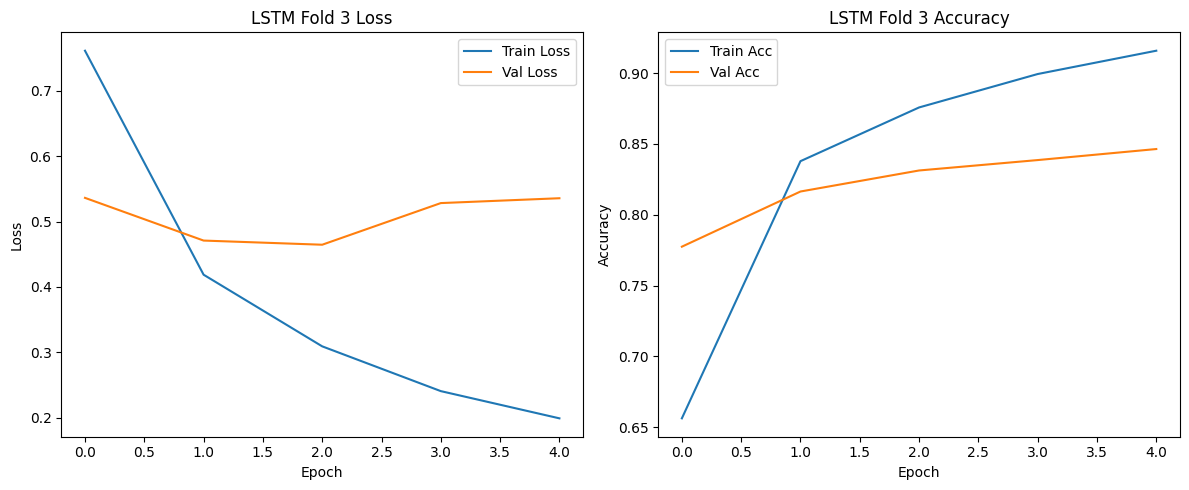

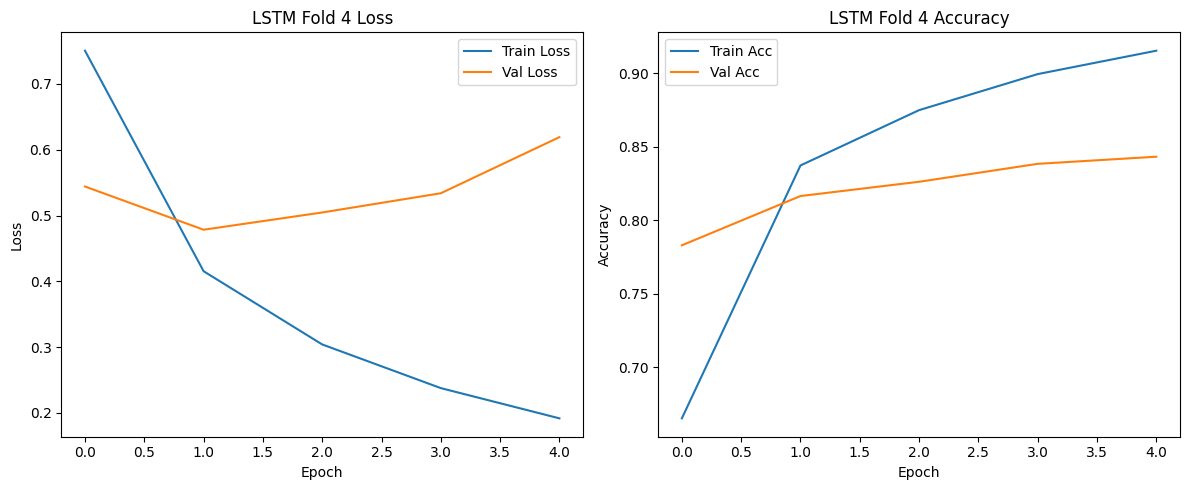

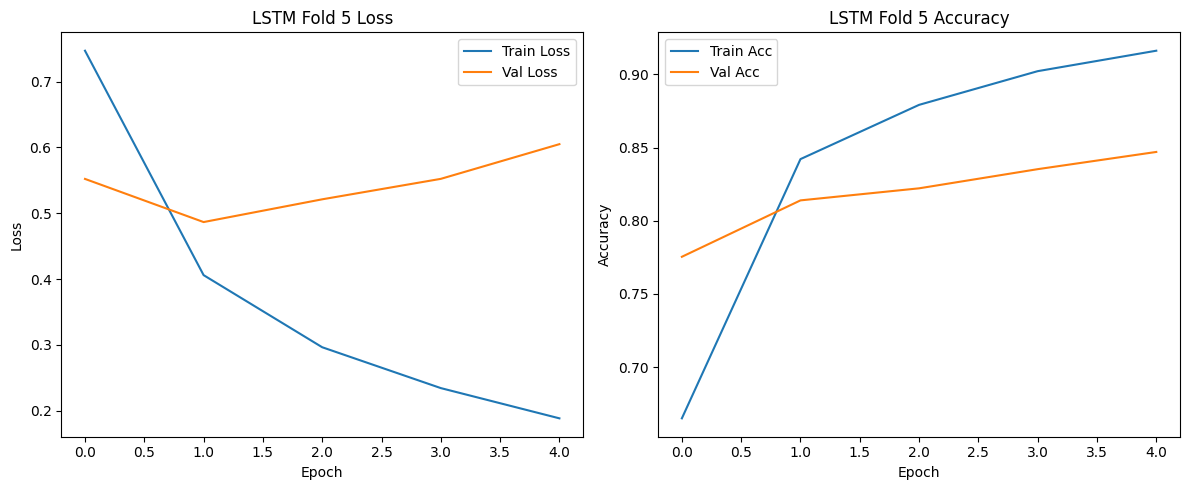

In [11]:
# Plot training/validation loss and accuracy curves
import matplotlib.pyplot as plt
for name in train_histories:
    for fold_idx, history in enumerate(train_histories[name]):
        plt.figure(figsize=(12, 5))
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{name} Fold {fold_idx+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{name} Fold {fold_idx+1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [12]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.8668
precision: 0.8669
recall: 0.8668
f1: 0.8666
mcc: 0.8005
mse: 0.1815
rmse: 0.4258
r2: 0.7277

RNN Average Metrics:
accuracy: 0.8437
precision: 0.8466
recall: 0.8437
f1: 0.8438
mcc: 0.7667
mse: 0.2174
rmse: 0.4645
r2: 0.6736

LSTM Average Metrics:
accuracy: 0.8471
precision: 0.8474
recall: 0.8471
f1: 0.8470
mcc: 0.7709
mse: 0.2082
rmse: 0.4561
r2: 0.6877


In [13]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [14]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print(f"\nOverall Best Model: {best}")
print(f"This is because {best} achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to the other two, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is CNN (score: 0.8668)
For precision, the winner is CNN (score: 0.8669)
For recall, the winner is CNN (score: 0.8668)
For f1, the winner is CNN (score: 0.8666)
For mcc, the winner is CNN (score: 0.8005)
For mse, the winner is CNN (score: 0.1815)
For rmse, the winner is CNN (score: 0.4258)
For r2, the winner is CNN (score: 0.7277)

Overall Best Model: CNN
This is because CNN achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to the other two, indicating it generalizes better on this sentiment classification task.


In [15]:
# After cross-validation, select the best model and tokenizer
# For example, if CNN is the best:
cnn_model = build_cnn(maxlen, vocab_size, num_classes)
cnn_model.fit(X, y_cat, epochs=5, batch_size=32, verbose=1)  # Train on full data
cnn_tokenizer = tokenizer  # If you used one tokenizer for all, otherwise assign the correct one

rnn_model = build_rnn(maxlen, vocab_size, num_classes)
rnn_model.fit(X, y_cat, epochs=5, batch_size=32, verbose=1)
rnn_tokenizer = tokenizer

lstm_model = build_lstm(maxlen, vocab_size, num_classes)
lstm_model.fit(X, y_cat, epochs=5, batch_size=32, verbose=1)
lstm_tokenizer = tokenizer

Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6981 - loss: 0.6906
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6981 - loss: 0.6906
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8771 - loss: 0.3201
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8771 - loss: 0.3201
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9254 - loss: 0.1945
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9254 - loss: 0.1945
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9429 - loss: 0.1445
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9429 - loss: 0.1445
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9497 - loss: 0.1181
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9497 - loss: 0.1181
Epoch 1/5
Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6963 - loss: 0.6816
Epoch 2/5
1063/1063 ━

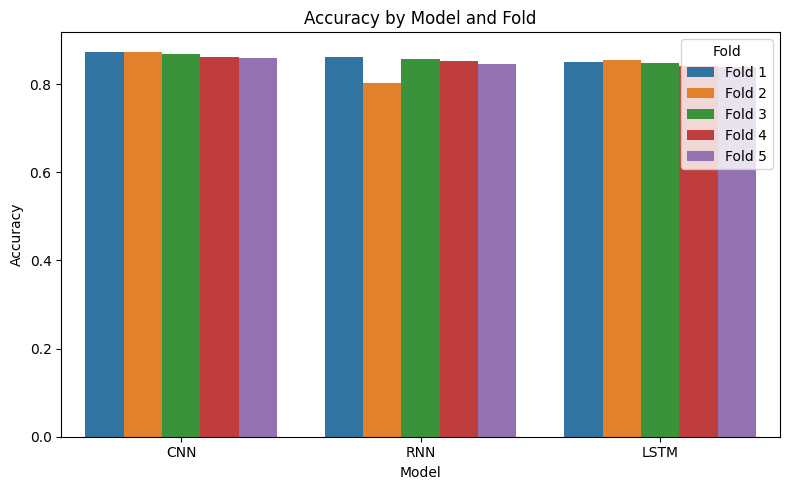

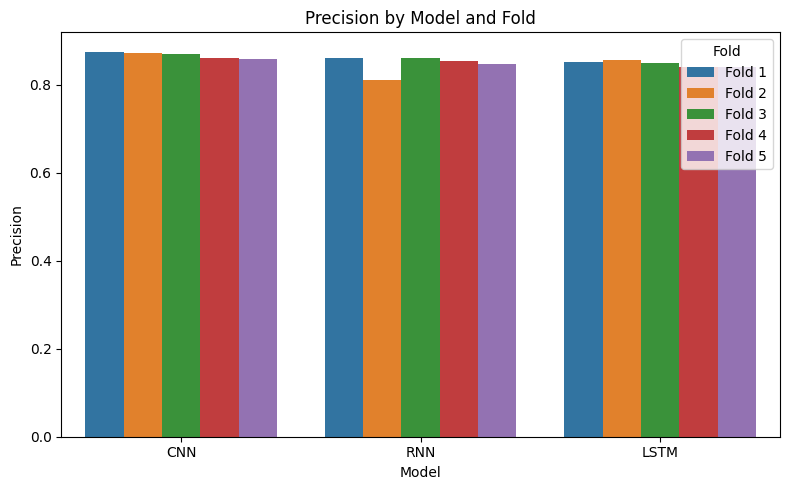

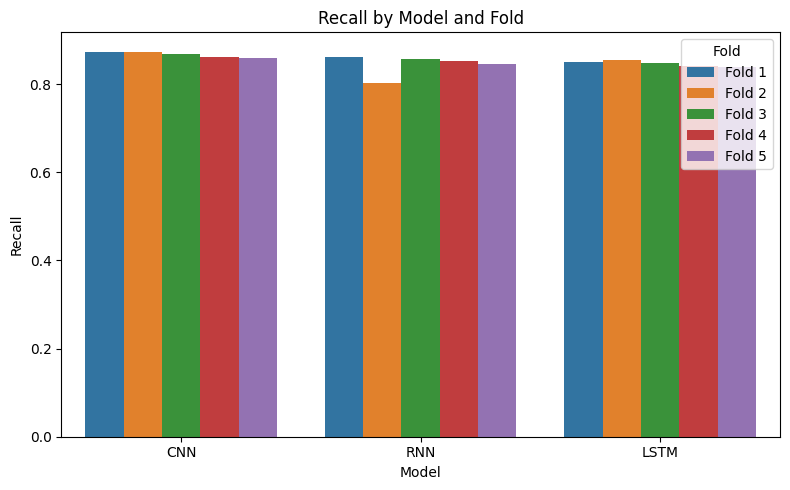

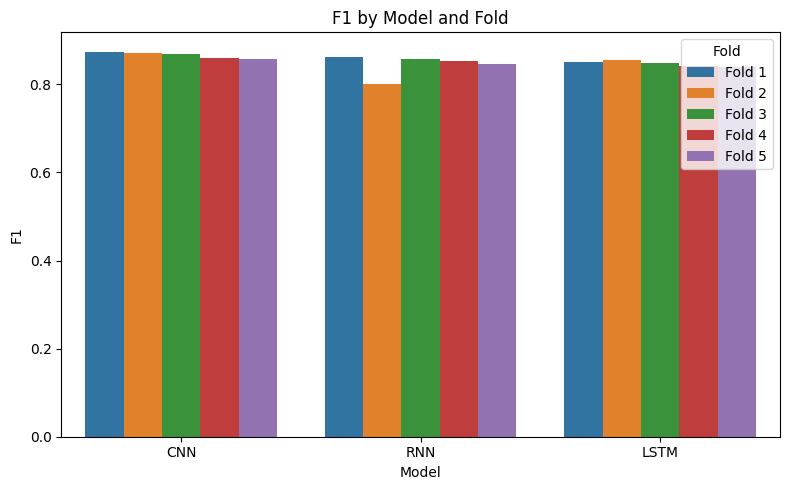

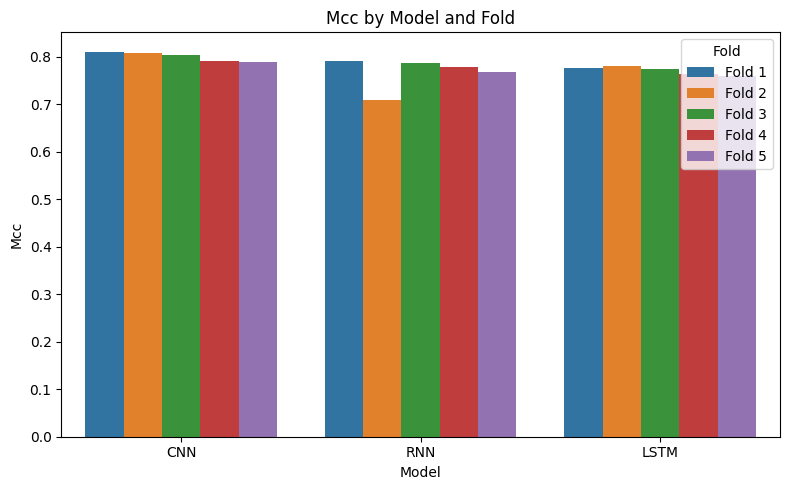

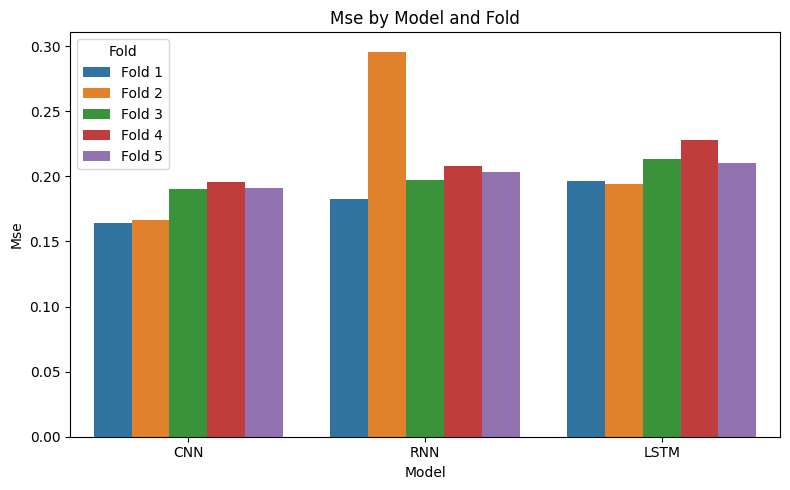

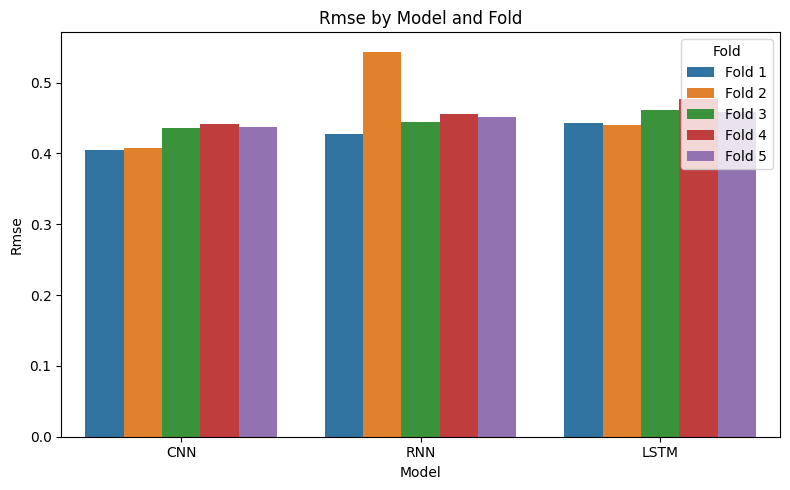

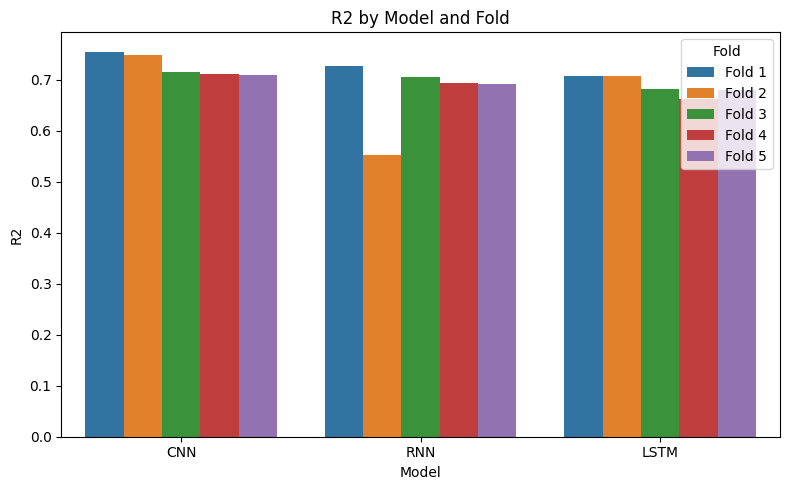

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

In [17]:
# import pickle

# models_dict = {'CNN': [cnn_fold1, cnn_fold2], ...}
# tokenizers_dict = {'CNN': [cnn_tokenizer_fold1, cnn_tokenizer_fold2], ...}

# for name in ['CNN', 'RNN', 'LSTM']:
#     for fold_idx, model in enumerate(models_dict[name]):
#         model_filename = f'{name.lower()}_fold{fold_idx+1}_model.h5'
#         tokenizer_filename = f'{name.lower()}_fold{fold_idx+1}_tokenizer.pkl'
#         # Save model
#         model.save(model_filename)
#         # Save corresponding tokenizer
#         with open(tokenizer_filename, 'wb') as f:
#             pickle.dump(tokenizers_dict[name][fold_idx], f)
#         print(f'Saved {model_filename} and {tokenizer_filename}')

In [18]:
import pickle

# Save CNN model and tokenizer
cnn_model.save('cnn_model.keras')
with open('cnn_tokenizer.obj', 'wb') as f:
    pickle.dump(cnn_tokenizer, f)

# Save RNN model and tokenizer
rnn_model.save('rnn_model.keras')
with open('rnn_tokenizer.obj', 'wb') as f:
    pickle.dump(rnn_tokenizer, f)

# Save LSTM model and tokenizer
lstm_model.save('lstm_model.keras')
with open('lstm_tokenizer.obj', 'wb') as f:
    pickle.dump(lstm_tokenizer, f)

print('Saved CNN, RNN, and LSTM models as .keras files and their tokenizers as .obj files.')

Saved CNN, RNN, and LSTM models as .keras files and their tokenizers as .obj files.
